# Get MRI and IMC data

**BMED360-2021**:  `Lab1-MRI`


<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/master/Lab1-MRI/00-get-mri-imc-data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### For using Colab
**--> the following libraries must be `pip installed` (i.e. uncommet the following pip commands):**

In [1]:
#!pip install gdown

In [2]:
#!pip install imageio

In [3]:
#!pip install tifffile

In [4]:
#!pip install scikit-image

In [5]:
#!pip install nibabel

In [6]:
#!pip install nilearn

**Download zipped data from Google Drive using** [`gdown`](https://github.com/wkentaro/gdown)

In [7]:
import gdown
import shutil
import os

In [8]:
#https://drive.google.com/file/d/1IAhrAGhaPAAjL4sFl_ymooNNjwWX55MI/view?usp=sharing
file_id = '1IAhrAGhaPAAjL4sFl_ymooNNjwWX55MI'
url = 'https://drive.google.com/uc?id=%s' % file_id
output = './data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IAhrAGhaPAAjL4sFl_ymooNNjwWX55MI
To: /Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab1-MRI/data.zip
41.4MB [00:08, 4.83MB/s]


'./data.zip'

**Unzip the data file into `./data/imc` and `./data/mri`**

In [9]:
shutil.unpack_archive(output, '.')

**Delete the `data.zip` file**

In [10]:
os.remove(output)

**Import libraries**

In [11]:
import sys
import json
import errno
import zipfile
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from pandas.core.common import flatten
import imageio
import skimage
from skimage import io
import tifffile as tiff
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import nilearn
from nilearn import plotting

# To display plots directly in the notebook:
%matplotlib inline

/Users/arvid/opt/anaconda3/envs/mmiv-dln-img/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [12]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Seaborn version ' + sns.__version__)
print('Imageio version ' + imageio.__version__)
print('Scikit-image version ' + skimage.__version__)
print('Tifffile version ' + tiff.__version__)
print('Nibabel version ' + nib.__version__)
print('Nlearn version ' + nilearn.__version__)

Python version 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:19) 
[Clang 9.0.0 (tags/RELEASE_900/final)]
Pandas version 1.2.3
Numpy version 1.19.5
Matplotlib version 3.3.4
Seaborn version 0.11.1
Imageio version 2.9.0
Scikit-image version 0.18.1
Tifffile version 2021.3.17
Nibabel version 3.2.1
Nlearn version 0.7.1


## Explore the MRI data

### We read a single slice four-channel MR image in DICOM-format 

In [13]:
channels = ['FLASH', 'DESS', 'FISP', 'PSIF']
nb_channels = len(channels)

In [14]:
print('Channels:')
chns = [print(f'./data/mri/{channel.lower()}_060.dcm') for channel in channels]

Channels:
./data/mri/flash_060.dcm
./data/mri/dess_060.dcm
./data/mri/fisp_060.dcm
./data/mri/psif_060.dcm


In [15]:
images = [imageio.imread(f'./data/mri/{channel.lower()}_060.dcm') for channel in channels]

Make a (2x2) figure (miltipanel display) of the channel images:

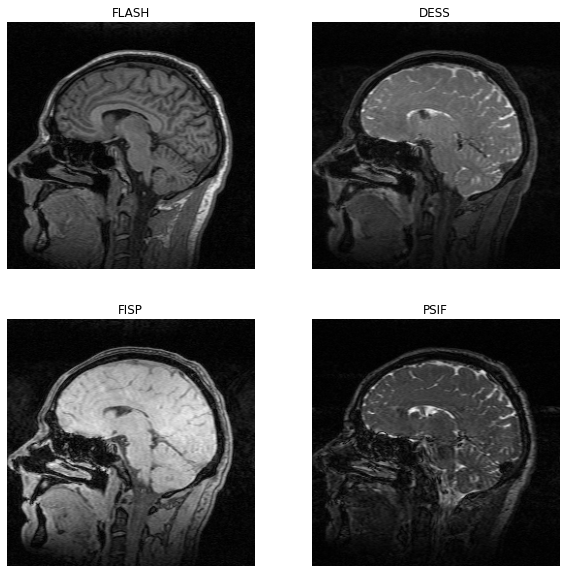

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()

for i, im in enumerate(images):
    ax[i].imshow(im, cmap='gray')
    ax[i].set_title(channels[i])
    ax[i].axis('off')

plt.show()

**Read PNG-files and display training masks (manual labelling of tissue types) and T1-weighted MR image data**

Color coded training mask shape: (256, 256, 3)


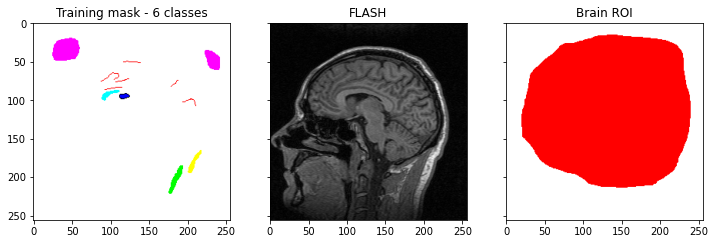

In [17]:
train_mask = imageio.imread("./data/mri/flash_060_training_mask_6cla.png")
roi_mask = imageio.imread("./data/mri/flash_060_brain_mask.png")
print(f'Color coded training mask shape: {train_mask.shape}')

fig, axes = plt.subplots(1, 3, figsize=(12, 18), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(train_mask)
ax[0].set_title("Training mask - 6 classes")
ax[1].imshow(images[0], cmap='gray')
ax[1].set_title("FLASH")
ax[2].imshow(roi_mask)
ax[2].set_title("Brain ROI")
plt.show()

**Count the number of occurences of pixels for each label in training mask**

In [18]:
from collections import Counter
Counter([tuple(colors) for i in train_mask for colors in i]).most_common()

[((255, 255, 255), 63519),
 ((255, 0, 255), 1250),
 ((0, 255, 0), 250),
 ((255, 255, 0), 170),
 ((255, 0, 0), 136),
 ((0, 255, 255), 129),
 ((0, 0, 255), 51),
 ((0, 0, 0), 31)]

### Display T1-weighted 3D head image

In [19]:
img = nib.load('./data/mri/0.0-test_nifti.nii.gz')

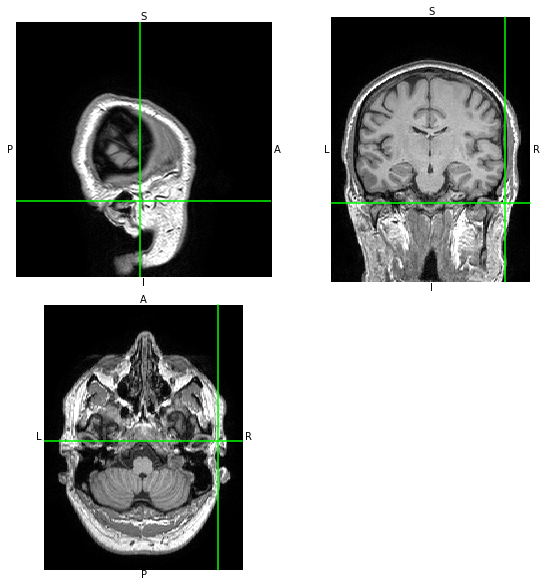

In [20]:
OrthoSlicer3D(img.get_fdata(), affine= img.affine).show()

### Display multichannel brain tumor data from the BraTS 2020 challenge

**Segmentation (HD-GLIO) info:**
- **CE**s: contrast-enhancing tumours (mask=1)
- **NE**s (non-enhancing T2-signal abnormalities, mask=2): defined as T2-FLAIR hyperintense abnormality excluding the contrast-enhancing and necrotic portion of the tumour, resection cavity, and obvious leukoaraiosis.
- Delineated volumetrically by experienced neuroradiologists
- We defined **tumour progression** as an increase in tumour volume (compared with baseline or best response) in either CE tumour or NEs, beyond a minimal tumour volume of 1 cm³; or occurrence of a new CE lesion outside of the CE tumour volume from the previous MRI scan (identified automatically using dedicated algorithms with the respective segmentation masks over time as input (cf. the appendix)

In [21]:
# AD HOC colormap for HD-GLIO  (CE, NE)-segmentation overlay
colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]  # R -> B -> G
n_bins = [2, 3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_cm'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins[0])

#### Calculate the CE (=1) and NE (=2) volumes
using `np.where()` and `np.prod(vox_size)`

In [22]:
def hdglio_ce_ne_volumes(fn_segm):
    
    
    img = nib.load(fn_segm)
    vox_size = img.header.get_zooms()
    vox_vol = np.prod(vox_size)
    data = img.get_fdata()
        
    # Find voxel locations (CE and NE roi) corresponding to hd_glio_pred segmentations  
    
    CE_roi = np.where(data == 1) 
    X_CE = np.asarray(data[CE_roi[0][:],CE_roi[1][:],CE_roi[2][:]]) # The MRI channel signal intensities in NE
    CE_vol = (len(X_CE.flatten())*vox_vol).astype(int)
    
    NE_roi = np.where(data == 2) 
    X_NE = np.asarray(data[NE_roi[0][:],NE_roi[1][:],NE_roi[2][:]]) # The MRI channel signal intensities in CE
    NE_vol = (len(X_NE.flatten())*vox_vol).astype(int)
            
    return vox_vol, CE_vol, NE_vol

In [23]:
## Calculate the CE (=1) and NE (=2) volumes using np.where() and np.prod(vox_size
fn_segm = './data/mri/BraTS20/BraTS20_Training_002_HDGlioSeg.nii.gz'
vox_vol, CE_vol, NE_vol = hdglio_ce_ne_volumes(fn_segm)
print(f'BraTS20_Training_002: CE-volume={CE_vol}, NE-volume={NE_vol}, vox_vol={vox_vol} (volumes in microL)\n')

BraTS20_Training_002: CE-volume=59379, NE-volume=6999, vox_vol=1.0 (volumes in microL)



**Inspect channels that are brain-extracted and coregistered**

In [24]:
chns = ['T1', 'CT1', 'T2', 'FLAIR']
chnsbrats = ['t1', 't1ce', 't2', 'flair']

In [25]:
# Cross cut coordinates, and dim values (emperically defined)
x, y, z = -102, 114, 55
dims = [-0.05, -0.7, -0.7, -0.7]

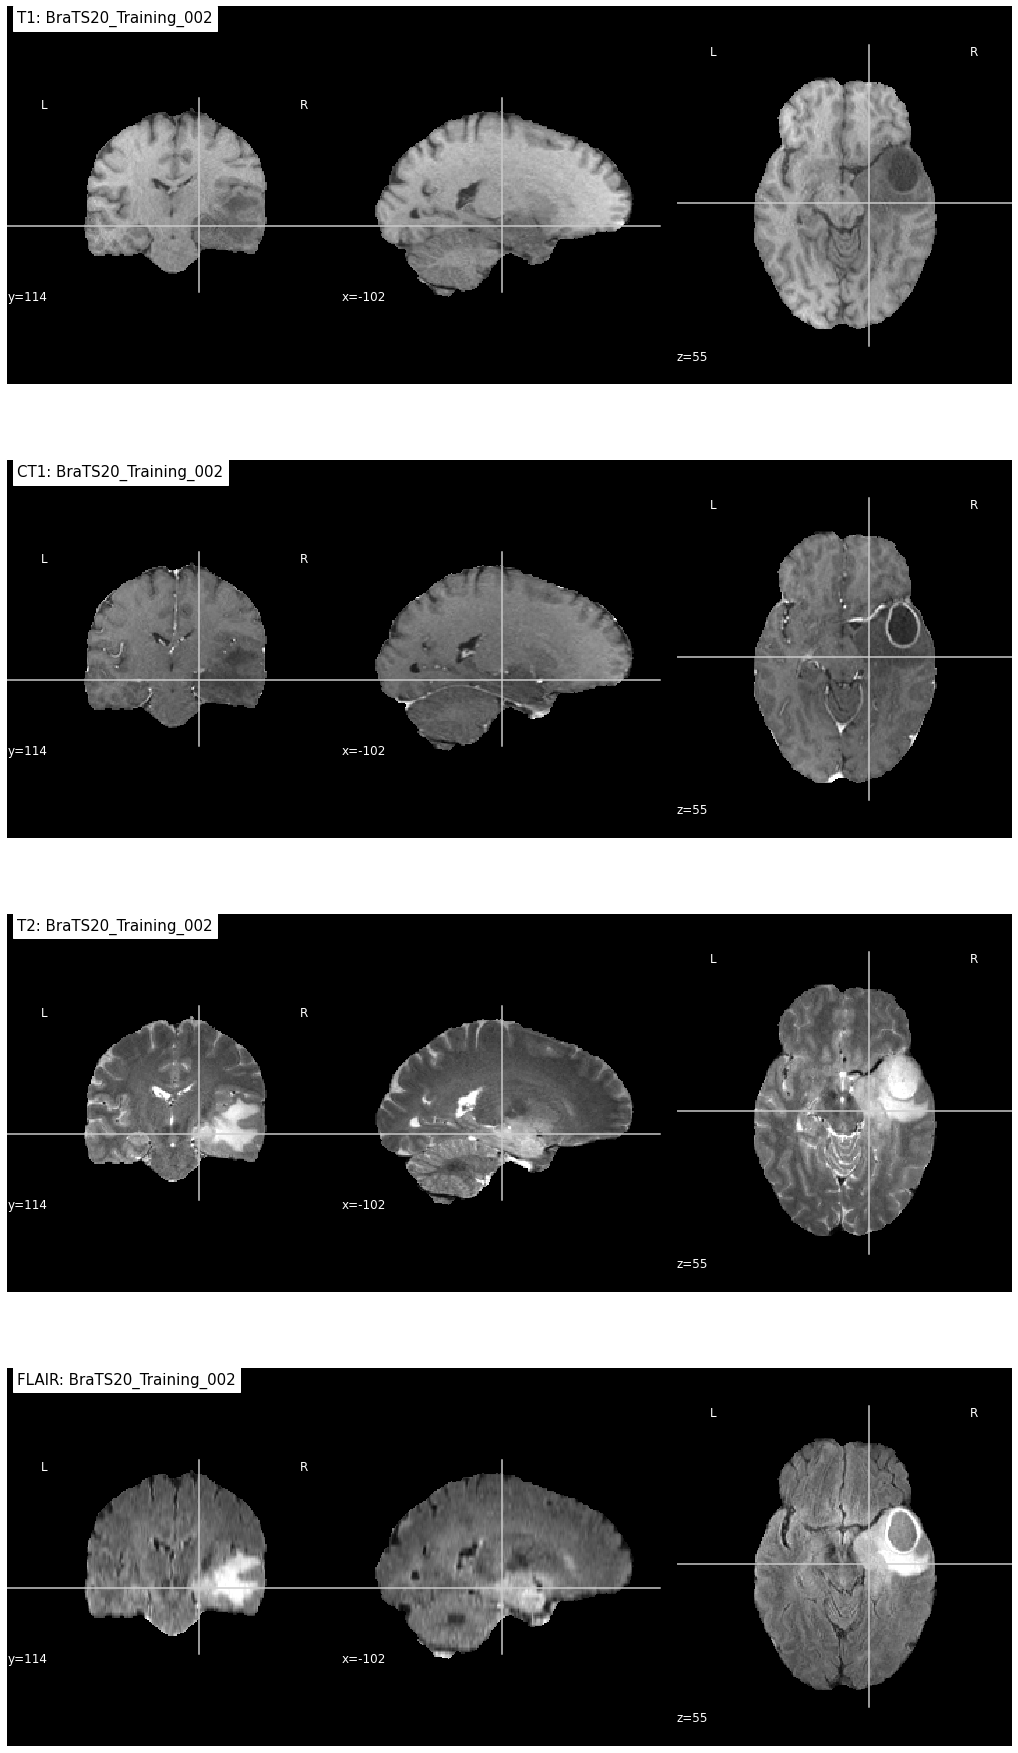

In [26]:
fig, axes  = plt.subplots(4, 1, figsize=(18,32))
k=0
for ax in axes.flatten():
    CH = chns[k]
    chn = chnsbrats[k]
    fn_inp = './data/mri/BraTS20/BraTS20_Training_002_%s.nii.gz' % chn
    tit = '%s: BraTS20_Training_002' % CH
    img = nib.load(fn_inp)
    plotting.plot_anat(img, axes = ax, title=tit, cmap="gray", dim=dims[k], cut_coords = (x, y, z))
    k=k+1
plt.show()

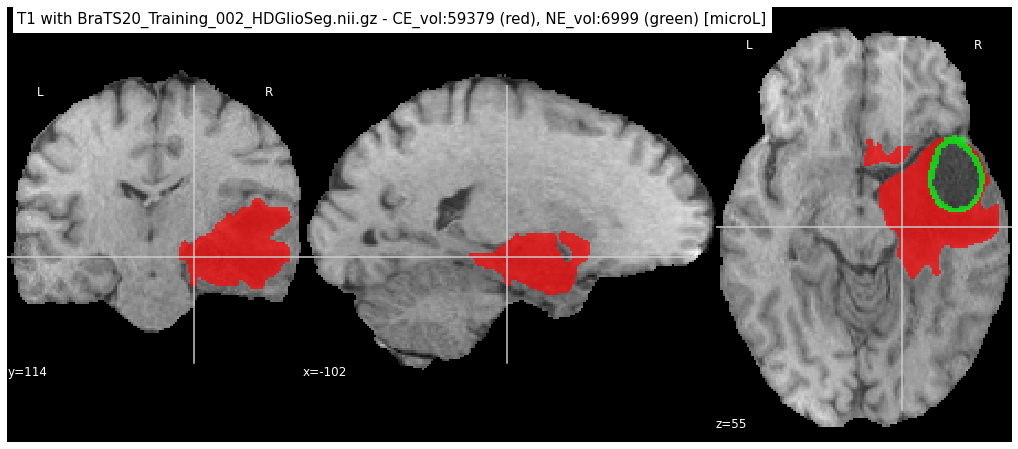

In [27]:
## Inspect HD-GLIO segmentation results
CH = 'T1'
chn = 't1'
fn_bg = './data/mri/BraTS20/BraTS20_Training_002_%s.nii.gz' % chn 
fn_segm = './data/mri/BraTS20/BraTS20_Training_002_HDGlioSeg.nii.gz'
bg_img = nib.load(fn_bg)
segm_img = nib.load(fn_segm)
tit = '%s with BraTS20_Training_002_HDGlioSeg.nii.gz - CE_vol:%d (red), NE_vol:%d (green) [microL]' % (CH, CE_vol, NE_vol )
fig, ax  = plt.subplots(1, 1, figsize=(18,8))
plotting.plot_roi(segm_img, bg_img, axes = ax, title=tit, cmap=cm, dim= -0.05, cut_coords = (x, y, z))
plt.show()

## Explore the IMC data 

### Read the IMC imagefile and the IMC meta files and display their characteristics

In [28]:
fn_tiff = './data/imc/E08_a0_full.tiff'
fn_csv = './data/imc/E08_a0_full.csv'
fn_panel = './data/imc/table1_IMC_panel_37x4.csv'

In [29]:
im = io.imread(fn_tiff)
n_chn = im.shape[0]

print(f'IMC image type: {type(im)}')
print(f'IMC image size: {im.shape}')
print(f'Number of IMC channels: {n_chn}')

IMC image type: <class 'numpy.ndarray'>
IMC image size: (37, 530, 567)
Number of IMC channels: 37


**Read the channel names into a Pandas dataframe**

In [30]:
df = pd.read_csv(fn_csv, usecols=[0], names=['chn'], header=None)
df.shape

(37, 1)

**Inspect the first 19 and the last 19 channel names**

In [31]:
df.head(19).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
chn,In113,In115,Pr141,Nd142,Nd143,Nd144,Nd145,Nd146,Sm147,Nd148,Sm149,Nd150,Sm152,Eu153,Sm154,Gd156,Gd158,Tb159,Gd160


In [32]:
df.tail(19).T

,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
chn,Gd160,Dy161,Dy162,Dy163,Dy164,Ho165,Er166,Er167,Er168,Tm169,Er170,Yb171,Yb172,Yb173,Yb174,Lu175,Yb176,Ir191,Ir193


#### Read the IMC dataset panel information into a dataframe and display the table
NOTE: The order of panel antigens is not the same as the order of channels in the IMC recordings

!! Inconsistency in Panel vs. IMC channel list (`175Yb` vs. `Lu175`) !!

In [33]:
df.chn.iloc[33]

'Lu175'

In [34]:
df.chn.iloc[33] = 'Yb175'
df.chn.iloc[33]

'Yb175'

In [35]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
chn,In113,In115,Pr141,Nd142,Nd143,Nd144,Nd145,Nd146,Sm147,Nd148,...,Tm169,Er170,Yb171,Yb172,Yb173,Yb174,Yb175,Yb176,Ir191,Ir193


In [36]:
from IPython.display import Image
# Image(filename = "./assets/Damond_etal_2019_Tab1_IMC_panel.png", width=700)   for running in Colab
url = 'https://raw.githubusercontent.com/MMIV-ML/MMIV-DLN-AI-2021/master/2-biomedical_imaging/assets/Damond_etal_2019_Tab1_IMC_panel.png'
Image(url=url)

In [37]:
df_p = pd.read_csv(fn_panel)
print(df_p.shape)
df_p

(37, 4)


,Short Name,Antigen,Main Target Cells,Metal Tag
0,INS,Insulin,β,141Pr
1,PIN,Proinsulin,β,154Sm
2,GCG,Glucagon,α,156Gd
3,SST,Somatostatin,δ,159Tb
4,PPY,Pancreatic polypeptide,γ,153Eu
5,NKX6-1,Homeobox protein Nkx-6.1,β,169Tm
6,PDX1,Pancreatic and duodenal homeobox 1,β δ ductal,158Gd
7,IAPP,Amylin,β,167Er
8,PCSK2,Proprotein convertase 2,α,144Nd
9,SYP,Synaptophysin,Endocrine,160Gd


**Insert IMC channel number in Panel data frame**

In [38]:
df_p['Chn'] = np.array(range(len(df.chn)))
for idx, val in enumerate(list(df.chn)):
    s = (val[2:]+val[:2])
    for idx2, val2 in enumerate(list(df_p['Metal Tag'])):
        if  s==val2:
            df_p.Chn.iloc[idx2] = idx+1
df_p

/Users/arvid/opt/anaconda3/envs/mmiv-dln-img/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Short Name,Antigen,Main Target Cells,Metal Tag,Chn
0,INS,Insulin,β,141Pr,3
1,PIN,Proinsulin,β,154Sm,15
2,GCG,Glucagon,α,156Gd,16
3,SST,Somatostatin,δ,159Tb,18
4,PPY,Pancreatic polypeptide,γ,153Eu,14
5,NKX6-1,Homeobox protein Nkx-6.1,β,169Tm,28
6,PDX1,Pancreatic and duodenal homeobox 1,β δ ductal,158Gd,17
7,IAPP,Amylin,β,167Er,26
8,PCSK2,Proprotein convertase 2,α,144Nd,6
9,SYP,Synaptophysin,Endocrine,160Gd,19


**Printing the panel data frame sorted by channel as a LaTeX table**

In [39]:
df_p_sort_chn = df_p.sort_values('Chn')
print(df_p_sort_chn.to_latex(index=True))

\begin{tabular}{lllllr}
\toprule
{} & Short Name &                                            Antigen &      Main Target Cells & Metal Tag &  Chn \\
\midrule
34 &         H3 &                                         Histone H3 &                 Nuclei &     113In &    1 \\
28 &        SMA &                                Smooth muscle actin &                Stromal &     115In &    2 \\
0  &        INS &                                            Insulin &                      β &     141Pr &    3 \\
25 &       CD38 &                                               CD38 &                 Immune &     142Nd &    4 \\
15 &       CD44 &                                               CD44 &               Exocrine &     143Nd &    5 \\
8  &      PCSK2 &                            Proprotein convertase 2 &                      α &     144Nd &    6 \\
10 &       CD99 &                                               CD99 &              Endocrine &     145Nd &    7 \\
22 &       CD68 &             

**Plot the IMC dataset as a 7 x 6 grid of color-coded channels**

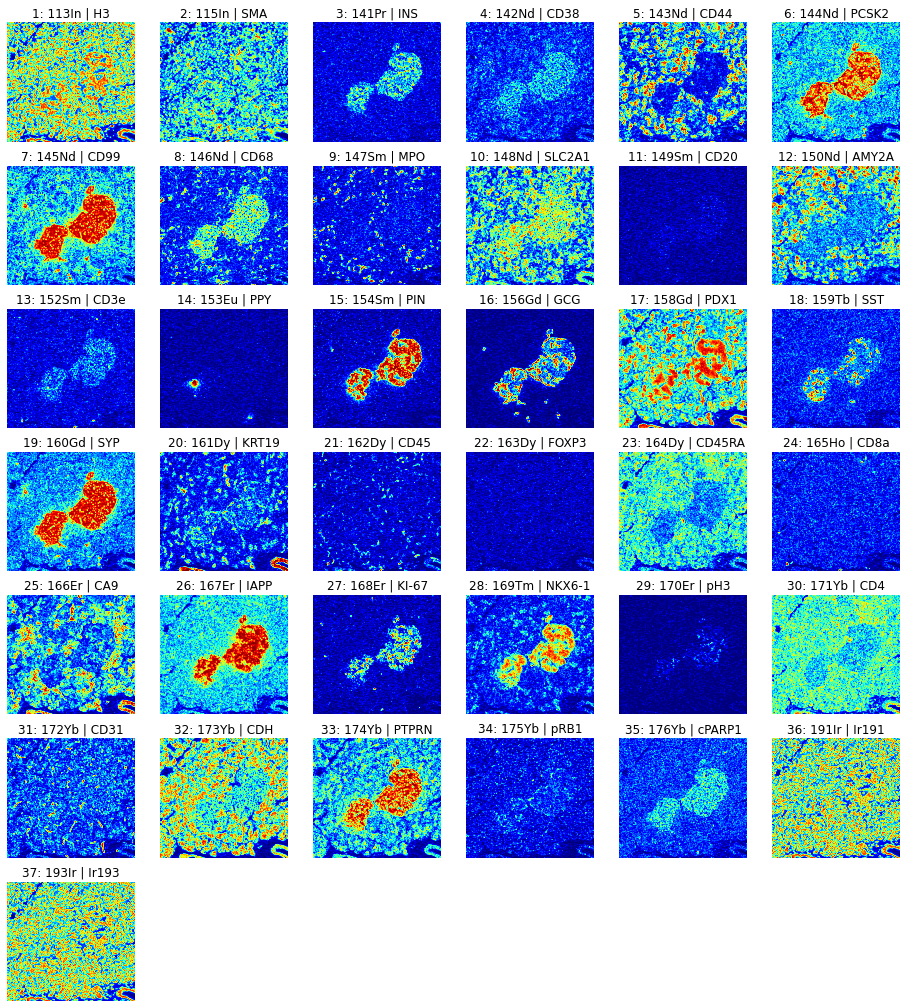

In [40]:
fig, axes = plt.subplots(7, 6, figsize=(16, 18), sharex=False, sharey=False)
ax = axes.ravel()
for i, item in enumerate(range(n_chn)):
    chn = np.squeeze(im[i,:,:])
    chn_eq = np.sort(chn.ravel()).searchsorted(chn)  # a kind of histogram equalization
    ax[i].imshow(chn_eq, cmap='jet' )   # cmap='jet', 'gray'
    ax[i].set_title('%d: %s | %s' % ((i+1), df_p_sort_chn['Metal Tag'].iloc[i], df_p_sort_chn['Short Name'].iloc[i]))
    ax[i].axis('off')
chn_0 = np.zeros(chn.shape )   
for j in range(n_chn,7*6):
    ax[j].imshow(chn_0, cmap='gray_r') 
    ax[j].axis('off')
#plt.savefig(fig_fn, bbox_inches='tight')
plt.show()